In [41]:
%matplotlib inline
import pylab as p
import numpy as np
import fsps

## Note: I just realized that I could've done all the math here instead of on Mathematica (out of habit), so sorry for not having that shown. :(

### Problem 1: UV Star Formation Rates

We wish to derive a relationship between the star formation rate and the FUV luminosity
\begin{align}
\log\dot{M_*}=\log L_{\rm FUV}-\log C_{\rm FUV}
\end{align}

where $C_{\rm FUV}$ is some as-yet undetermined constant. We run FSPS, assuming a constant star formation history, a Kroupa IMF, and solar metallicity.

In [91]:
sp = fsps.StellarPopulation(compute_vega_mags=False,sfh=1,const=1.0)
sp.params['sfh'] = 1
sp.params['const'] = 1.0
#sp.params['tage'] = 13.7

We are interested in the GALEX-FUV filter, and so we use that value to infer the star formation rate. Note that FSPS gives answers in terms of the AB-magnitude system, so we have to convert this to get a luminosity $L_{\rm FUV}$. An AB-Magnitude is defined as
\begin{align}
M_{\rm AB}=-2.5\log_{10}F_\nu - 48.6
\end{align}

The specific luminosity in terms of the specific flux is
\begin{align}
F_\nu = \frac{L_\nu}{4\pi r^2}
\end{align}

where $r=10$ pc. We are interested in the total FUV luminosity rather than the FUV luminosity, so we need to solve for
\begin{align}
L_{\rm FUV}=\nu L_\nu
\end{align}

where $\nu$ is the effective GALEX FUV frequency. The all-powerful and all-knowing internet provides us with the effective wavelength

\begin{align}
\lambda_{\rm eff} = 153.9\,\,{\rm nm}
\end{align}

Backtracking everything, we finally find

\begin{align}
L_{\rm FUV} = 4\pi r^2 \frac{c}{\lambda}\,{\rm pow}(-(M_{\rm AB}+48.6)/2.5,10)
\end{align}

FSPS tells us that at present-day, assuming constant SFH, the GALEX FUV filter gives
\begin{align}
M_{\rm AB} = 6.2
\end{align}

So we get a luminosity

\begin{align}
\log_{10}L_{\rm FUV} = 33.4
\end{align}
I found an FSPS SFR of
\begin{align}
\log_{10}\dot{M}_*=-10.1
\end{align}

And so

\begin{align}
\log_{10}C_{\rm FUV} &= \log_{10}L_{\rm FUV}-\log_{10}\dot{M}_* \\
&= 43.5
\end{align}

In [11]:
mag = sp.get_mags(tage=13.7,bands=fsps.find_filter('galex_fuv'))
sfr = sp.sfr
mag,sfr

(array([ 6.2191321]), 7.2992700729927016e-11)

Kennicutt & Evans (2012) found that $\log_{10}C_{\rm FUV}=43.35$, which is only slightly different than what I had found. Since this is of order a few percent, I can only speculate what some of the differences would be caused by. Observations apply a dust-correction, so maybe this is where the (small) discrepancy comes from.

### Problem 2: Stellar Mass

Was really confused by this problem...

array([-0.59389204,  2.55366857])

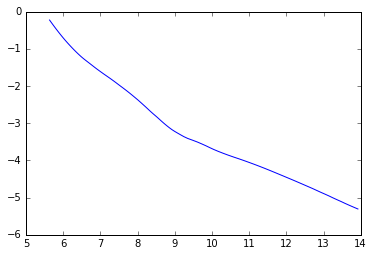

In [103]:
mag_b = sp.get_mags(bands=['b'])
mass = sp.stellar_mass

p.plot(mag_b, np.log10(mass))

np.polyfit(mag_b[:,0],np.log10(mass),1)


### Problem 3: Metallicity

First we need to find the absolute B-band magnitudes $M_B$ from the galaxy sample. So we need to solve for the distance modulus
\begin{align}
\mu = -5(\log_{10}d-1)
\end{align}

In [45]:
dist = np.loadtxt("galaxies.dat",skiprows=1,usecols=[7]) #in Mpc
mag_b = np.loadtxt("galaxies.dat",skiprows=1,usecols=[8]) #apparent B

In [46]:
dist_modulus = -5.*np.log10(dist*1e6)+5
abs_b = mag_b + dist_modulus

Next, we can use Eq. (8) from Berg et al. (2012) to find the metallicity

\begin{align}
12+\log(O/H) = (6.59\pm0.32)+(-0.08\pm0.03)M_B
\end{align}

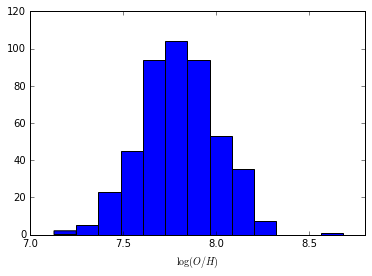

In [108]:
z_oh = 6.59-0.08*abs_b

p.hist(z_oh,bins=13)
p.xlabel(r'$\log(O/H)$')
p.show()

### Problem 4: Trends in SFR, Mass, and Metallicity

In [104]:
mass = 2.6-0.6*abs_b

In [130]:
fuv = np.loadtxt("galaxies.dat",skiprows=1,usecols=[11])
fuv_err = np.loadtxt("galaxies.dat",skiprows=1,usecols=[12])
nonzero = np.where(fuv!=99.99)
fuv = fuv[nonzero]
fuv_err = fuv_err[nonzero]

fuv_lum = np.log10(4*np.pi*(10*3e18)**2*3e10/(153.9e-7)*10**(-(fuv+48.6)/2.5))
sfr = fuv_lum-43.5

mass_nonzero = mass[nonzero]
mets = z_oh[nonzero]

(6, 16)

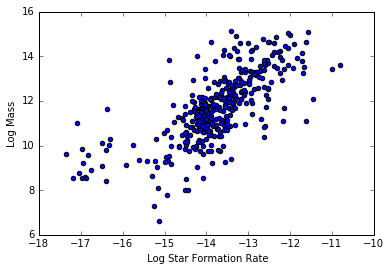

In [124]:
p.scatter(sfr,mass_nonzero)
p.xlabel(" Log Star Formation Rate")
p.ylabel("Log Mass")
p.xlim(-18,-10)
p.ylim(6,16)

In [117]:
import emcee
import corner

def lnlikelihood(theta,sfr,mass):
    chi_sq = np.sum((mass-theta[0]*sfr-theta[1])**2)
    return -.5*chi_sq

def lnprior(theta):
    return 0.0

def lnposterior(theta,sfr,mass):
    prior = lnprior(theta)
    likelihood = lnlikelihood(theta,sfr,mass)
    return prior + likelihood

nwalkers = 100
p0 = np.random.rand(2*nwalkers).reshape((nwalkers,2))
sampler = emcee.EnsembleSampler(nwalkers,2,lnposterior,args=[sfr,mass_nonzero])
sampler.run_mcmc(p0,1000)

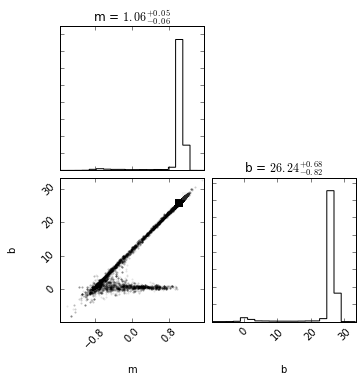

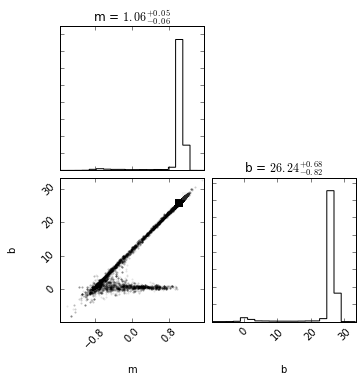

In [121]:
corner.corner(sampler.chain.reshape((-1,2)),labels=['m','b'],show_titles=True)

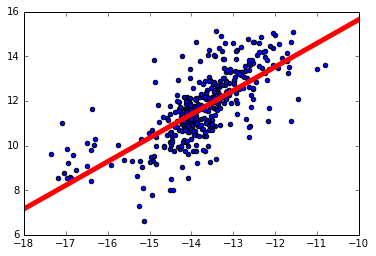

In [129]:
fsfr = np.linspace(-18,-10,100)
fmass = 1.06*fsfr+26.24

p.plot(fsfr,fmass,'red',lw=5)
p.scatter(sfr,mass_nonzero)
p.xlim(-18,-10)
p.ylim(6,16)
p.show()

(-18, -10)

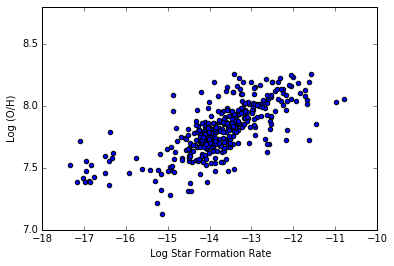

In [134]:
p.scatter(sfr,mets)
p.xlabel(" Log Star Formation Rate")
p.ylabel("Log (O/H)")
p.xlim(-18,-10)
#p.ylim(6,16)

In [131]:
nwalkers = 100
p0 = np.random.rand(2*nwalkers).reshape((nwalkers,2))
sampler = emcee.EnsembleSampler(nwalkers,2,lnposterior,args=[sfr,mets])
sampler.run_mcmc(p0,1000)

(array([[  8.00955082e-02,   8.84778960e+00],
        [  1.61148378e-01,   9.99121817e+00],
        [  8.27154180e-02,   9.01864567e+00],
        [  1.70954713e-01,   1.01431234e+01],
        [  1.02865596e-01,   9.16399816e+00],
        [  1.08360864e-01,   9.28923000e+00],
        [  1.76999101e-01,   1.01456313e+01],
        [  1.51545362e-01,   1.00092942e+01],
        [  9.60950627e-02,   9.05064322e+00],
        [  1.40597209e-01,   9.71407113e+00],
        [  1.73713404e-01,   1.01966744e+01],
        [  2.02174486e-01,   1.05635408e+01],
        [  8.99058711e-02,   9.07308469e+00],
        [  1.22887337e-01,   9.52872206e+00],
        [ -1.66575579e-03,   7.83913426e+00],
        [  1.36655063e-01,   9.75567501e+00],
        [  1.90551570e-01,   1.03197618e+01],
        [  1.86963271e-01,   1.02909185e+01],
        [  1.57217558e-01,   9.86570612e+00],
        [  2.44186294e-01,   1.11622506e+01],
        [  1.51520407e-01,   9.86942719e+00],
        [  1.57376147e-01,   9.926

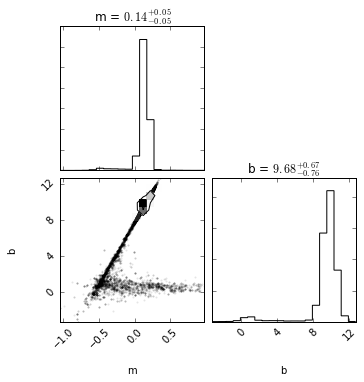

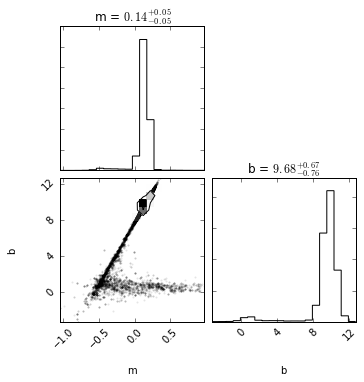

In [132]:
corner.corner(sampler.chain.reshape((-1,2)),labels=['m','b'],show_titles=True)

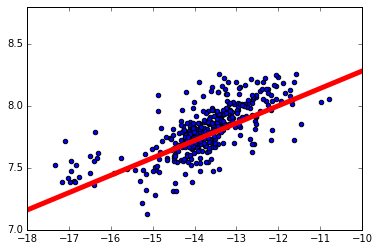

In [133]:
fsfr = np.linspace(-18,-10,100)
fmet = 0.14*fsfr+9.68

p.plot(fsfr,fmet,'red',lw=5)
p.scatter(sfr,mets)
p.xlim(-18,-10)
#p.ylim(6,16)
p.show()

### Caveats

I didn't fold in the errors when I performed the fits (I probably should have). Also, There's uncertainty in the metallicity equation from Berg et al. (2012) that I also didn't fold in. A more thorough MCMC accounting for this would be more beneficial.

I think that knowing the star formation history would help alleviate some of this scatter. We had earlier assumed a constant star formation history, which is obviously inaccurate.